In [7]:
from numba import cuda
import networkx as nx
from itertools import combinations, groupby
import random
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

import graphcuda

cuda.gpus

### Pre-compile for [CuPy's JIT](https://docs.cupy.dev/en/stable/user_guide/performance.html#context-initialization)

In [8]:
graphcuda.generate_random_graph(1, 1)
graphcuda.generate_random_adjacency_matrix(1, 1)

array([[0.]])

### Parameters

In [3]:
n_nodes   = 10000
prob_edge = 1.2/(100-1)

# Test runs
K = 5

### Test original NetworkX approach

In [9]:
def gnp_random_connected_graph(n, p):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = random.random()*100
    return G

In [5]:
avg_time = 0
for _ in tqdm(range(K)):
    start = time.perf_counter()
    G = gnp_random_connected_graph(n_nodes, prob_edge)
    end = time.perf_counter()
    avg_time += end - start
avg_time /= K

print(f'NetworkX Generation Average Time: {avg_time:.03f} secs')

100%|██████████| 5/5 [01:12<00:00, 14.58s/it]

NetworkX Generation Average Time: 14.581 secs


### Test original Matrix Masking + CuPy approach

In [6]:
avg_time = 0
for _ in tqdm(range(K)):
    start = time.perf_counter()
    G = graphcuda.generate_random_graph(n_nodes, prob_edge)
    end = time.perf_counter()
    avg_time += end - start
avg_time /= K

print(f'Masking-CuPy Generation Average Time: {avg_time:.03f} secs')

100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

Masking-CuPy Generation Average Time: 5.296 secs


### (Adjacency Matrix Only) Test original Matrix Masking + CuPy approach

In [9]:
avg_time = 0
for _ in tqdm(range(K)):
    start = time.perf_counter()
    G = graphcuda.generate_random_adjacency_matrix(n_nodes, prob_edge)
    end = time.perf_counter()
    avg_time += end - start
avg_time /= K

print(f'(Adjacency) Masking-CuPy Generation Average Time: {avg_time:.03f} secs')

100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

(Adjacency) Masking-CuPy Generation Average Time: 0.583 secs


## Comparing all implementations across N

In [10]:
N = np.arange(100, 16000, 1000, dtype=int)
prob_edge = 1.2/(100-1)

nx_times = []
gpu_times = []
adj_only_times = []

for n in tqdm(N, position=0, desc='N', leave=False, ncols=80):
    start = time.perf_counter()
    gnp_random_connected_graph(n, prob_edge)
    end = time.perf_counter()
    nx_times.append(end - start)

    start = time.perf_counter()
    graphcuda.generate_random_graph(n, prob_edge)
    end = time.perf_counter()
    gpu_times.append(end - start)

    start = time.perf_counter()
    graphcuda.generate_random_adjacency_matrix(n, prob_edge)
    end = time.perf_counter()
    adj_only_times.append(end - start)

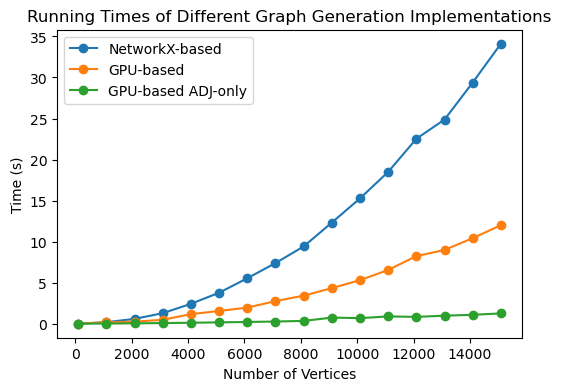

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(N, nx_times, '-o', label='NetworkX-based')
plt.plot(N, gpu_times, '-o', label='GPU-based')
plt.plot(N, adj_only_times, '-o', label='GPU-based ADJ-only')
plt.title("Running Times of Different Graph Generation Implementations")
plt.xlabel("Number of Vertices")
plt.ylabel('Time (s)')
plt.legend()
plt.savefig('./figures/gen_times.png', dpi=300)

## GPU-based adjacency matrix only

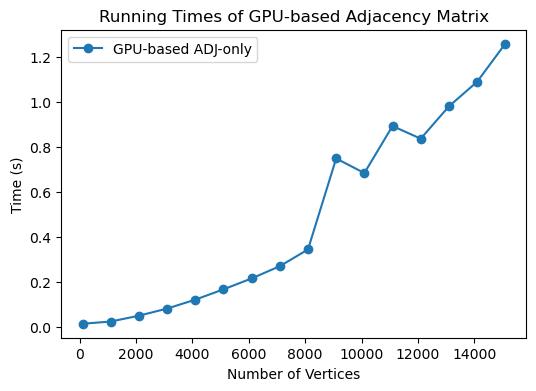

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(N, adj_only_times, '-o', label='GPU-based ADJ-only')
plt.title("Running Times of GPU-based Adjacency Matrix")
plt.xlabel("Number of Vertices")
plt.ylabel('Time (s)')
plt.legend()
plt.savefig('./figures/gen_times_adj.png', dpi=300)